In [1]:
pip install torch torchvision matplotlib numpy torchinfo lightning


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torchvision.transforms import ToTensor, Compose, Resize, Lambda, RandomHorizontalFlip, RandomRotation
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib.pyplot import subplots
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint




In [3]:
import os
import pandas as pd

Cells_Data = pd.DataFrame(columns=["class", "filepath"])

for root, dirs, files in os.walk("archive"):
    if os.path.basename(root) == "CROPPED":
        class_name = os.path.basename(os.path.dirname(root))
        
        for file in files:
            if file.endswith(".bmp"):
                file_path = os.path.join(root, file)
                Cells_Data = pd.concat([Cells_Data, pd.DataFrame({
                    "class": [class_name],
                    "filepath": [file_path]
                })], ignore_index=True)

"Total de imagens .bmp:", len(Cells_Data)

('Total de imagens .bmp:', 4049)

In [4]:
from PIL import Image
from torch.utils.data import Dataset

class CellsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        # Mapeia cada classe para um índice numérico
        self.class_to_idx = {cls: i for i, cls in enumerate(self.data["class"].unique())}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, "filepath"]
        label = self.class_to_idx[self.data.loc[idx, "class"]]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



In [5]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, RandomRotation

transform = Compose([
    Resize((128, 128)),
    RandomHorizontalFlip(),
    RandomRotation(10),
    ToTensor()
])


In [6]:
full_dataset = CellsDataset(Cells_Data, transform=transform)

# tamanhos do split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # para reprodutibilidade
)


In [7]:
val_size = int(0.2 * train_size)
train_size_final = train_size - val_size

train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size_final, val_size],
    generator=torch.Generator().manual_seed(42)
)


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=31)
test_loader = DataLoader(test_dataset, batch_size=32)


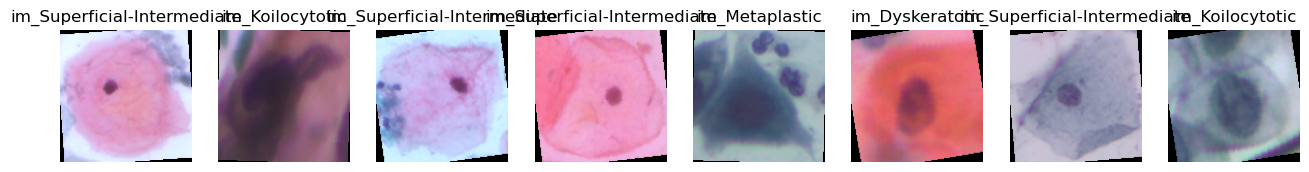

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# pegar um batch do dataloader
images, labels = next(iter(train_loader))

# converter tensor para numpy (para visualização)
images = images.numpy().transpose((0, 2, 3, 1))  # [B, H, W, C]
labels = labels.numpy()

# função auxiliar para mostrar imagens
def show_images(imgs, labels, class_names, n=8):
    plt.figure(figsize=(16, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# Recupera os nomes das classes do dataset original
class_names = list(full_dataset.class_to_idx.keys())

# mostra 8 imagens aleatórias
show_images(images, labels, class_names, n=8)


In [68]:
class BuildingBlock(nn.Module):
    def __init__(self ,
                    in_channels ,
                    out_channels):
        super(BuildingBlock , self).__init__ ()
        self.conv = nn.Conv2d(in_channels=in_channels ,
                                out_channels=out_channels ,
                                kernel_size =(3 ,3),
                                padding='same')
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU ()
        self.pool = nn.MaxPool2d(kernel_size =(2 ,2))
    def forward(self , x):
      return self.pool(self.activation(self.bn(self.conv(x))))

In [69]:
sizes = []

for path in Cells_Data["filepath"].sample(200):  # pega 200 amostras pra não demorar
    with Image.open(path) as img:
        sizes.append(img.size)  # (w, h)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
print(sizes_df.describe())


            width      height
count  200.000000  200.000000
mean   220.995000  199.965000
std     96.051258   93.663805
min     68.000000   49.000000
25%    145.000000  130.000000
50%    207.000000  173.000000
75%    287.000000  270.750000
max    490.000000  475.000000


In [70]:
class CVD_Model(nn.Module):
    def __init__(self):
        super(CVD_Model, self).__init__()
        sizes = [(3, 32), (32, 64), (64, 128)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_) for in_, out_ in sizes])
        
        self.gap = nn.AdaptiveAvgPool2d((7, 7))  # garante 7x7 em qualquer entrada
        
        self.output = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*128, 1024),   # usa o último número de filtros da conv
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        val = self.conv(x)
        val = self.gap(val)
        val = torch.flatten(val, 1)
        return self.output(val)


In [71]:
class CVD_Small(nn.Module):
    """2 blocos conv + 2 lineares"""
    def __init__(self, num_classes=5):
        super().__init__()
        sizes = [(3, 64),   
                 (64, 128)]  
        self.conv = nn.Sequential(
            *[BuildingBlock(cin, cout) for cin, cout in sizes]
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # --- PARTE FULLY‑CONNECTED ---
        self.output = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 64),  # 1ª camada linear
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)  # 2ª camada linear (saída)
        )
    def forward(self, x):
        x = self.conv(x)       # [B, 64, H/4, W/4]
        x = self.avgpool(x)        # [B, 64, 1, 1]
        x = torch.flatten(x, 1)    # [B, 64]
        x = self.output(x)     # [B, num_classes]
        return x



In [72]:
cvd_model = CVD_Model()
summary(cvd_model ,
input_data= torch.randn(1, 3, 224, 224),
col_names =['input_size',
'output_size',
'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVD_Model                                [1, 3, 224, 224]          [1, 5]                    --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 128, 28, 28]          --
│    └─BuildingBlock: 2-1                [1, 3, 224, 224]          [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 3, 224, 224]          [1, 32, 224, 224]         896
│    │    └─BatchNorm2d: 3-2             [1, 32, 224, 224]         [1, 32, 224, 224]         64
│    │    └─ReLU: 3-3                    [1, 32, 224, 224]         [1, 32, 224, 224]         --
│    │    └─MaxPool2d: 3-4               [1, 32, 224, 224]         [1, 32, 112, 112]         --
│    └─BuildingBlock: 2-2                [1, 32, 112, 112]         [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 32, 112, 112]         [1, 64, 112, 112]         18,496
│    │    └─BatchNorm2d: 3-6  

In [73]:
cvd_model_small = CVD_Small()
summary(cvd_model_small ,
input_data= torch.randn(1, 3, 224, 224),
col_names =['input_size',
'output_size',
'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVD_Small                                [1, 3, 224, 224]          [1, 5]                    --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 128, 56, 56]          --
│    └─BuildingBlock: 2-1                [1, 3, 224, 224]          [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 3, 224, 224]          [1, 64, 224, 224]         1,792
│    │    └─BatchNorm2d: 3-2             [1, 64, 224, 224]         [1, 64, 224, 224]         128
│    │    └─ReLU: 3-3                    [1, 64, 224, 224]         [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-4               [1, 64, 224, 224]         [1, 64, 112, 112]         --
│    └─BuildingBlock: 2-2                [1, 64, 112, 112]         [1, 128, 56, 56]          --
│    │    └─Conv2d: 3-5                  [1, 64, 112, 112]         [1, 128, 112, 112]        73,856
│    │    └─BatchNorm2d: 3-

In [74]:
class LitCVDModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CVD_Model() 
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
        

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001)


In [75]:
class LitCVDSmall(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CVD_Small() 
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
        

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001)

In [76]:
model = LitCVDModel()


checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="best-cvd-model",
    verbose=True
)

trainer = Trainer(
    accelerator="auto",  
    devices=1,
    max_epochs=120,
    precision=16,         
    log_every_n_steps=10,
    callbacks=[checkpoint_callback]
    
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


/home/al.lucas.barcelos/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
model = LitCVDModel.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.lucas.barcelos/anaconda3/envs/ambiente_aluno/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9444444179534912
        test_loss           0.19220460951328278
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.19220460951328278, 'test_acc': 0.9444444179534912}]

In [ ]:
model_small = LitCVDSmall()


checkpoint_callback_small = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="best-cvd-model-small",
    verbose=True
)

trainer = Trainer(
    accelerator="auto",  
    devices=1,
    max_epochs=120,
    precision=16,         
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_small]
    
)

trainer.fit(model_small, train_dataloaders=train_loader, val_dataloaders=val_loader)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | CVD_Small        | 84.6 K | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
84.6 K    Trainable params
0         Non-trainable params
84.6 K    Total params
0.338     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 81: 'val_acc' reached 0.68934 (best 0.68934), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 162: 'val_acc' reached 0.70634 (best 0.70634), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 243: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 324: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 405: 'val_acc' reached 0.79753 (best 0.79753), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 486: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 567: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 648: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 729: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 810: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 891: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 972: 'val_acc' reached 0.82844 (best 0.82844), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1053: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1134: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 1215: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 1296: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 1377: 'val_acc' reached 0.85162 (best 0.85162), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 1458: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 1539: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1620: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1701: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1782: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1863: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1944: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 2025: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 2106: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 2187: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 2268: 'val_acc' reached 0.85935 (best 0.85935), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 2349: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 2430: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 2511: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 2592: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 2673: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 2754: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 2835: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 2916: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 2997: 'val_acc' reached 0.87017 (best 0.87017), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 3078: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 3159: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 3240: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 3321: 'val_acc' reached 0.89181 (best 0.89181), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 3402: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 3483: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 3564: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 3645: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 3726: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 3807: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 3888: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 3969: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 4050: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 4131: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 4212: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 4293: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 4374: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 4455: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 4536: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 4617: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 4698: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 4779: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 4860: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 4941: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 5022: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 5103: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 5184: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 5265: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 5346: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 5427: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 5508: 'val_acc' reached 0.89335 (best 0.89335), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 5589: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 5670: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 5751: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 5832: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 5913: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 5994: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 6075: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 6156: 'val_acc' reached 0.90417 (best 0.90417), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 6237: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 6318: 'val_acc' reached 0.90881 (best 0.90881), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 6399: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 6480: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 6561: 'val_acc' reached 0.91190 (best 0.91190), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 6642: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 6723: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 6804: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 6885: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 6966: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 7047: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 7128: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 7209: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 7290: 'val_acc' reached 0.91808 (best 0.91808), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 7371: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 7452: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 7533: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 7614: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 7695: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 7776: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 7857: 'val_acc' reached 0.91963 (best 0.91963), saving model to '/home/al.lucas.barcelos/Cervical_/lightning_logs/version_16/checkpoints/best-cvd-model-small.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 7938: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 8019: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 8100: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 100, global step 8181: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 101, global step 8262: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 102, global step 8343: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 103, global step 8424: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 104, global step 8505: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 105, global step 8586: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 106, global step 8667: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 107, global step 8748: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 108, global step 8829: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 109, global step 8910: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 110, global step 8991: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 111, global step 9072: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 112, global step 9153: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 113, global step 9234: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 114, global step 9315: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 115, global step 9396: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 116, global step 9477: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 117, global step 9558: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 118, global step 9639: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 119, global step 9720: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=120` reached.


In [ ]:
model_small = LitCVDSmall.load_from_checkpoint(checkpoint_callback_small.best_model_path)
trainer.test(model_small, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.924691379070282
        test_loss           0.21008208394050598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.21008208394050598, 'test_acc': 0.924691379070282}]

In [10]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_conv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features = [64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #down
        for feature in features:
            self.downs.append(double_conv(in_channels, feature))
            in_channels = feature

        #up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(double_conv(feature*2, feature))
            ch = feature
        
        self.bottleneck = double_conv(features[-1], features[-1]*2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.final_conv = nn.Linear(ch, 1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]

            if x.shape[-2:] != skip_connection.shape[-2:]:
                x = F.interpolate(x, size=skip_connection.shape[-2:], mode='bilinear', align_corners=False)

                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](concat_skip)
        

        x = self.gap(x).flatten(1)
        return self.final_conv(x)

In [ ]:
class UNetEncoderClassifier(nn.Module):
  
    def __init__(self, in_ch=3, feat=[16, 32, 64, 128]):  
        super().__init__()

        self.downs = nn.ModuleList()
        self.pool  = nn.MaxPool2d(2, 2)

        in_channels = in_ch
        for f in feat:
            self.downs.append(double_conv(in_channels, f))
            in_channels = f

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(in_channels, 5)  

    def forward(self, x):
        for down in self.downs:
            x = down(x)
            x = self.pool(x)

        x = self.gap(x).flatten(1)  
        return self.fc(x)

In [24]:
def teste_tamanho():
    x = torch.randn(1, 1, 128, 128)
    model = UNetEncoderClassifier(in_ch=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
teste_tamanho()


torch.Size([1, 5])
torch.Size([1, 1, 128, 128])


In [25]:
class LitUNetEncoderClassifier(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model   = UNetEncoderClassifier()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, stage):
        x, y = batch
        y = y.long()       
        logits = self(x)                  
        loss   = self.loss_fn(logits, y)

        
        preds = torch.argmax(logits, dim=1)
        acc   = (preds == y).float().mean()

        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_acc",  acc,  prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", patience=3, factor=0.5
        )
        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler, "monitor": "val_acc", "interval": "epoch", "frequency":1}}


In [26]:
model_unet_ida = LitUNetEncoderClassifier()

checkpoint_callback_unet_ida = ModelCheckpoint(
    monitor="val_acc",
    mode = "max",
    save_top_k = 1,
    filename="best-unet-ida-classifier")

trainer = Trainer(
    accelerator = "auto",
    devices=1,
    max_epochs=100,
    precision=16,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback_unet_ida]
)

trainer.fit(model_unet_ida, train_dataloaders=train_loader, val_dataloaders=val_loader)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                  | Params | Mode 
----------------------------------------------------------
0 | model   | UNetEncoderClassifier | 296 K  | train
1 | loss_fn | CrossEntropyLoss      | 0      | train
----------------------------------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.185     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [27]:
model_unet_ida = LitUNetEncoderClassifier.load_from_checkpoint(checkpoint_callback_unet_ida.best_model_path)
trainer.test(model_unet_ida, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9629629850387573
        test_loss           0.11495069414377213
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.11495069414377213, 'test_acc': 0.9629629850387573}]